In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'letters_gen_1_attn_test'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
#sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
#sample_data = sample_data[sample_data['class'] != 'MANUAL']

sample_data =  sample_data[sample_data['class'] == 'LETTERS']

print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 152986,  (dropped rows: 9765206)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['LETTERS']
1


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
%%timeit
balanced_data_sample_row()

105 µs ± 751 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
LETTERS    20000
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                                               512765
token_id                                                      12
class                                                    LETTERS
before                                                        CD
after                                                        c d
class_org                                                LETTERS
a_word_ind                                           [21, 26, 0]
sentence       the first drama cd was released in september 1...
Name: 103986, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

LETTERS : GHz -> g h z <EOS> [53, 45, 105, 0]
iqrf is a technology for wireless packet oriented communication via radio frequency ( rf ) in sub <SAMPLE> ism bands .
torch.Size([1, 4, 104])


In [17]:
%%timeit
get_random_sample()

151 µs ± 898 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [19]:
MAX_ATTENTION_LENGTH = 10

### Encoder

In [208]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        #all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        #output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1].view(-1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            #hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[:,ei]), 1)
            hidden_states_cat[ei] = all_outputs_chars[0,ei]
                
        #output = torch.cat((output_words, output_chars), 1)
        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output_chars, hidden_states_cat #all_outputs_chars

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [209]:
encoder_rnn.load_state_dict(torch.load('data/models/numbers_gen_8_attention/50000_EncoderRNN'))

In [220]:
string_t = ""
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t)
    
encoder_output, encoder_outputs = test_encoder_single_sample()
encoder_output.size()
encoder_outputs.size()


FC


torch.Size([256])

torch.Size([10, 256])

### Decoder

In [221]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)

        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(256, 256, batch_first=True)
  (lin_out): Linear (256 -> 1351)
  (embedding): Embedding(1351, 256)
  (attn): Linear (512 -> 10)
  (attn_combine): Linear (512 -> 256)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 256]), torch.Size([1, 10])]

In [222]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [223]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 256]), torch.Size([1, 10])]

Variable containing:
 465
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

sad


# Training etc

### Accuracy

In [224]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_intput = torch.LongTensor([word_index])
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory',
 'savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory',
 'g h',
 ('GH',
  [53, 45, 0],
  'LETTERS',
  'york had previously auditioned for two other roles on <SAMPLE> but was rejected .'))

In [225]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

L.             => savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory || [42, 0] 
                  " sergeant ola <SAMPLE> mize " .
BTH            => t's savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory savory || [36, 30, 45, 0] 
                  in 2012 , the transaxle yo yo sleep time record was broken by the c3 yoyodesign <SAMPLE> , with a time of 30 : 28 . 30 minutes .


### Training

In [227]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_intput = torch.LongTensor([word_index])
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [228]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0: # or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [229]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/letters_gen_1_attn_test_3


In [230]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   6.944   |   7.02: nsu -> t's <EOS> <EOS> (✗: [29, 17, 43, 0]) (forcing)
    18  36% (   0m 0s)   5.813   |   3.55: V. ->  (✗: [54, 0]) 
    27  54% (   0m 0s)   5.604   |   2.27: S. W. ->  (✗: [17, 52, 0]) 
    36  72% (   0m 0s)   5.290   |   3.53: J. ->  (✗: [60, 0]) 
    45  90% (   0m 0s)   5.085   |   1.69: PDF ->  (✗: [24, 26, 37, 0]) 


In [231]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 5s)   2.464   |   2.58: LPL -> p <EOS> <EOS> (✗: [42, 24, 42, 0]) (forcing)


In [238]:
train_iterations(n_iters=9000, lr=0.001, print_every=1000)

  2000  11% (  0m 12s)   1.805   |   2.25: GWB -> b b i (✗: [53, 52, 36, 0]) (forcing)
  3000  22% (  0m 26s)   1.101   |   2.16: AZ -> a a (✗: [22, 105, 0]) 
  4000  33% (  0m 39s)   0.697   |   0.38: K- -> k (✓) (forcing)
  5000  44% (  0m 52s)   0.507   |   0.25: DSL -> d s l (✓) 
  6000  56% (   1m 5s)   0.323   |   0.01: N. -> n (✓) 
  7000  67% (  1m 17s)   0.244   |   0.01: K. -> k (✓) 
  8000  78% (  1m 30s)   0.174   |   0.23: IOLR -> i o r r (✗: [31, 25, 42, 35, 0]) (forcing)
  9000  89% (  1m 43s)   0.143   |   0.00: PDF -> p d f (✓) (forcing)
 10000 100% (  1m 56s)   0.183   |   0.00: NFL -> n f l (✓) (forcing)


In [ ]:
train_iterations(n_iters=90000, print_every=10000)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

input:   ['P', 'D', 'F']
output:  ['p', 'd', 'f']
target:    p d f


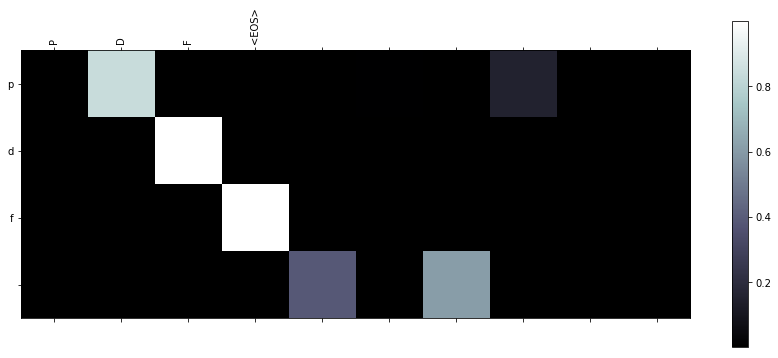

In [250]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    #output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input: ', [words_after_common[w] for w in sample[1]])
    print(output)

    showAttention(input_sentence, output_words, attentions)

    
output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
print('input:  ', list(sample[0]))
print('output: ', decoded_output)
print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

debug_show_attention(list(sample[0]), decoded_output, attns)

#debug_eval_sample_show_attention()
#tmp = [r/sum(r) for r in attns]
#plt.matshow(tmp)
#plt.matshow(attns)


In [ ]:
plt.matshow(attns)

In [ ]:
tmp = [r/sum(r) for r in attns]
plt.matshow(tmp)

In [ ]:
np.argmax(attns, 1)
[attns[k,v] for k, v in enumerate(np.argmax(attns, 1))]